# **Data-Preprocessing And Augmentation**

In [48]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [4]:
tf.__version__

'2.10.0'

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
images = tf.data.Dataset.list_files('data/train/images/*.jpg')
images

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [21]:
images.as_numpy_iterator().next(), 


(b'data\\train\\images\\6f7cb937-efb0-11ee-a812-5811223dab1e.jpg',)

In [22]:
def load_img(file):
    byte_img = tf.io.read_file(file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [23]:
images = images.map(load_img)

In [24]:
tempimg = images.as_numpy_iterator().next()
tempimg

array([[[134, 128, 130],
        [131, 125, 127],
        [132, 123, 126],
        ...,
        [237, 228, 229],
        [237, 229, 227],
        [236, 228, 226]],

       [[133, 127, 127],
        [131, 125, 125],
        [132, 123, 124],
        ...,
        [238, 229, 230],
        [238, 230, 228],
        [238, 230, 228]],

       [[131, 128, 123],
        [130, 127, 122],
        [131, 126, 122],
        ...,
        [237, 231, 231],
        [240, 232, 230],
        [240, 232, 230]],

       ...,

       [[ 13,  18,  12],
        [ 12,  17,  11],
        [ 11,  16,   9],
        ...,
        [113, 113, 105],
        [115, 114, 109],
        [115, 114, 109]],

       [[ 12,  17,  11],
        [ 11,  16,  10],
        [ 12,  15,   8],
        ...,
        [111, 112, 104],
        [111, 112, 106],
        [111, 112, 106]],

       [[ 11,  16,  10],
        [ 11,  16,  10],
        [ 13,  16,   9],
        ...,
        [107, 108, 100],
        [106, 109, 102],
        [105, 108, 101]]

In [25]:
tempimg.shape

(480, 640, 3)

In [26]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# **Viewing raw imgs:**

In [28]:
img_generator = images.batch(4).as_numpy_iterator()
plot_imgs = img_generator.next()
plot_imgs.shape

(4, 480, 640, 3)

In [31]:
type(plot_imgs), plot_imgs.shape

(numpy.ndarray, (4, 480, 640, 3))

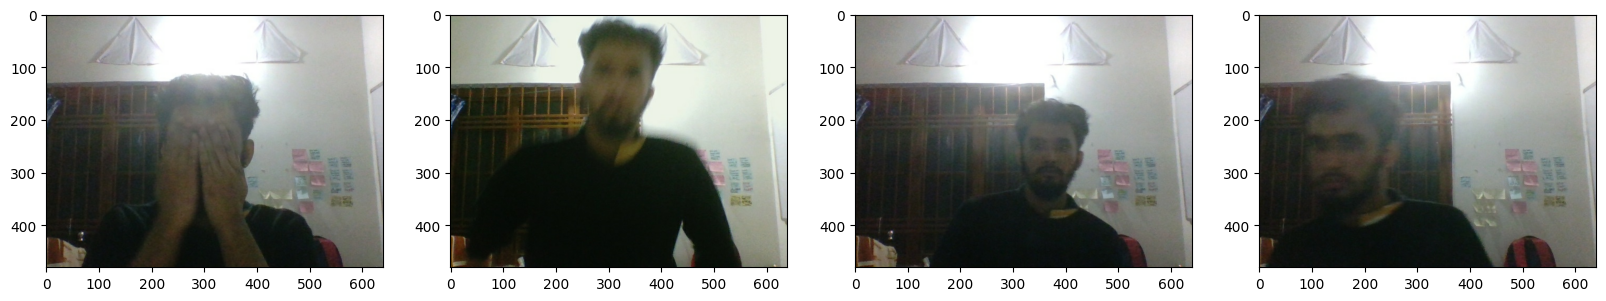

In [36]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(plot_imgs):
    axs[idx].imshow(img)
plt.show()

In [39]:
import os
# os.getcwd()

'e:\\FaceDetection'

* **Manually, splitting unaugmented Data into `train`, `test`, `val` sets.**

In [41]:
print(len(os.listdir('data/train/images')))
print(len(os.listdir('data/val/images')))
print(len(os.listdir('data/test/images')))

84
18
18


* **Moving matching labels**

In [42]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

* **Applying Data Augmentation:**

In [45]:
import albumentations as alb

In [46]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

* **`Testing` augmentation on a single img**

In [56]:
img = cv.imread('E:/FaceDetection/data/train/images/0f811b0f-efb0-11ee-a435-5811223dab1e.jpg')
img.shape

(480, 640, 3)

In [57]:
with open(os.path.join('data', 'train', 'labels', '0f811b0f-efb0-11ee-a435-5811223dab1e.json'),
          'r') as file:
    label = json.load(file)

In [58]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'Face',
   'points': [[173.6111111111111, 113.33333333333333],
    [380.8333333333333, 386.6666666666667]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\0f811b0f-efb0-11ee-a435-5811223dab1e.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYn

In [59]:
label['shapes'][0]['points']

[[173.6111111111111, 113.33333333333333],
 [380.8333333333333, 386.6666666666667]]

In [63]:
coords = [label['shapes'][0]['points'][0][0],\
          label['shapes'][0]['points'][0][1],\
          label['shapes'][0]['points'][1][0],\
          label['shapes'][0]['points'][1][1],]
coords

[173.6111111111111, 113.33333333333333, 380.8333333333333, 386.6666666666667]

In [64]:
# normalizing
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.27126736111111105,
 0.2361111111111111,
 0.5950520833333333,
 0.8055555555555556]

In [66]:
aug = augmentor(image = img, bboxes = [coords], class_labels=['face'])

In [67]:
aug

{'image': array([[[ 21,  21,  15],
         [ 20,  20,  14],
         [ 19,  19,  13],
         ...,
         [ 30,  53,  79],
         [ 28,  55,  81],
         [ 41,  75,  98]],
 
        [[ 20,  23,  14],
         [ 19,  22,  13],
         [ 18,  21,  12],
         ...,
         [ 29,  53,  81],
         [ 21,  52,  77],
         [ 41,  79, 103]],
 
        [[ 19,  22,  13],
         [ 18,  21,  12],
         [ 18,  21,  12],
         ...,
         [ 27,  51,  81],
         [ 22,  52,  79],
         [ 48,  86, 110]],
 
        ...,
 
        [[216, 215, 217],
         [215, 214, 216],
         [215, 215, 215],
         ...,
         [126, 136, 136],
         [126, 136, 136],
         [125, 135, 135]],
 
        [[215, 214, 216],
         [216, 216, 216],
         [216, 216, 216],
         ...,
         [127, 137, 137],
         [125, 135, 135],
         [126, 136, 136]],
 
        [[216, 216, 216],
         [215, 215, 215],
         [215, 216, 214],
         ...,
         [128, 136,

In [68]:
aug.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [69]:
aug['bboxes']

[(0.1670370370370372,
  0.17407407407407402,
  0.6275308641975309,
  0.7814814814814814)]

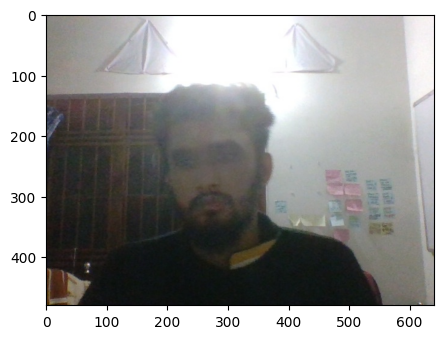

In [83]:
# Original Img:
plt.figure(figsize=(5, 5))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
# fig, axs = plt.subplots(1, 2)
# axs[0] =  plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
# axs[1] =  plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

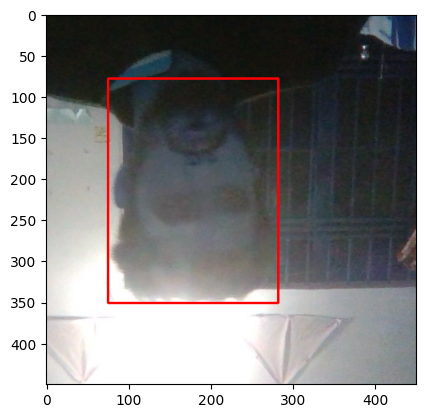

In [86]:
# Augmented image {one of the many variations that could be done}:
cv.rectangle(aug['image'],
            tuple(np.multiply(aug['bboxes'][0][:2], [450,450]).astype(int)),
            tuple(np.multiply(aug['bboxes'][0][2:], [450,450]).astype(int)),
            (255,0,0), 2)

plt.imshow(aug['image'])

* **Augmentation Pipeline:**


In [89]:
# Creating `aug_data` folders:
partitions = ['train', 'test', 'val']
if not os.path.exists('aug_data'):
    for partition in partitions:
        os.makedirs(os.path.join('aug_data', partition, 'images'))
        os.makedirs(os.path.join('aug_data', partition, 'labels'))

In [88]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# **Rough Work(experimentation):...**
* **Will add to to model training code `@Later`**

* **`augmented images` ==> `tf Dataset`**

In [112]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
test_images  = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
val_images   = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)

In [113]:
train_images = train_images.map(load_img)
train_images = train_images.map(lambda img: tf.image.resize(img, (120, 120)))
train_images = train_images.map(lambda img: img/255.)

In [114]:
test_images = test_images.map(load_img)
test_images = test_images.map(lambda img: tf.image.resize(img, (120, 120)))
test_images = test_images.map(lambda img: img/255.)

In [115]:
val_images = val_images.map(load_img)
val_images = val_images.map(lambda img: tf.image.resize(img, (120, 120)))
val_images = val_images.map(lambda img: img/255.)

In [96]:
# train_images.as_numpy_iterator().next()

array([[[0.49509802, 0.50392157, 0.47316176],
        [0.47132352, 0.48014706, 0.44632354],
        [0.47855392, 0.4810049 , 0.44963235],
        ...,
        [0.075     , 0.09362745, 0.0882353 ],
        [0.07218137, 0.09509804, 0.08033089],
        [0.06329657, 0.08682598, 0.07113971]],

       [[0.4833946 , 0.4918505 , 0.4428309 ],
        [0.4971814 , 0.49803922, 0.4509804 ],
        [0.5069853 , 0.49669117, 0.45992646],
        ...,
        [0.06617647, 0.09117647, 0.0759804 ],
        [0.06317402, 0.08817402, 0.07297794],
        [0.0596201 , 0.09105392, 0.07310049]],

       [[0.4916054 , 0.5183824 , 0.43805146],
        [0.49583334, 0.5140319 , 0.43835783],
        [0.48167893, 0.4930147 , 0.4276348 ],
        ...,
        [0.05931373, 0.09460784, 0.09068628],
        [0.06268382, 0.09411765, 0.10177696],
        [0.05814951, 0.09344362, 0.0846201 ]],

       ...,

       [[1.        , 1.        , 0.99215686],
        [0.9920956 , 0.9999387 , 0.99601716],
        [0.98376226, 0

* **For `labels`:**

In [116]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [117]:
# loading
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)

# mapping: load_labels
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [104]:
# train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4377, 0.1787, 0.8955, 0.782 ], dtype=float16))

* **Combining label and img samples:**

In [118]:
len(train_images), len(train_labels)

(5040, 5040)

In [108]:
len(test_images), len(test_labels)

(1080, 1080)

In [109]:
len(val_images), len(val_labels)

(1080, 1080)

In [132]:
# Final datasets:
train = tf.data.Dataset.zip((train_images, train_labels))
test = tf.data.Dataset.zip((test_images, test_labels))
val = tf.data.Dataset.zip((val_images, val_labels))

In [122]:
len(train), len(test), len(val)

(5040, 1080, 1080)

In [133]:
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [134]:
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [135]:
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [131]:
# train.as_numpy_iterator().next()[0]

array([[[[0.2401348 , 0.23590687, 0.2098652 ],
         [0.26127452, 0.24050245, 0.22009803],
         [0.2887255 , 0.25637254, 0.23100491],
         ...,
         [0.24675246, 0.23498775, 0.19969362],
         [0.25539216, 0.24007353, 0.1973652 ],
         [0.24607843, 0.23039216, 0.18480392]],

        [[0.22303921, 0.22175245, 0.2148897 ],
         [0.22702205, 0.21280637, 0.20153186],
         [0.2617647 , 0.24264705, 0.22800244],
         ...,
         [0.24197304, 0.23020834, 0.19491422],
         [0.24313726, 0.23480392, 0.18921569],
         [0.24901961, 0.2403799 , 0.19479166]],

        [[0.20833333, 0.20833333, 0.20833333],
         [0.20980392, 0.20980392, 0.20980392],
         [0.21421568, 0.21378677, 0.20594363],
         ...,
         [0.2504902 , 0.23872548, 0.2112745 ],
         [0.24748774, 0.23572303, 0.21427695],
         [0.2547794 , 0.23811275, 0.21568628]],

        ...,

        [[0.7814951 , 0.78541666, 0.7658088 ],
         [0.78909314, 0.7935049 , 0.77389705]

In [130]:
# train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.2522, 0.387 , 0.8325],
        [0.3384, 0.2444, 0.7793, 0.8013],
        [0.472 , 0.2264, 0.957 , 0.8657],
        [0.2446, 0.1059, 0.777 , 0.803 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2256, 0.2815, 0.632 , 0.732 ],
        [0.5757, 0.2888, 1.    , 0.895 ],
        [0.5176, 0.1805, 1.    , 0.83  ]], dtype=float16))

* **Viewing imgs and annotations:**

In [136]:
data_samples = train.as_numpy_iterator()

In [137]:
res = data_samples.next()

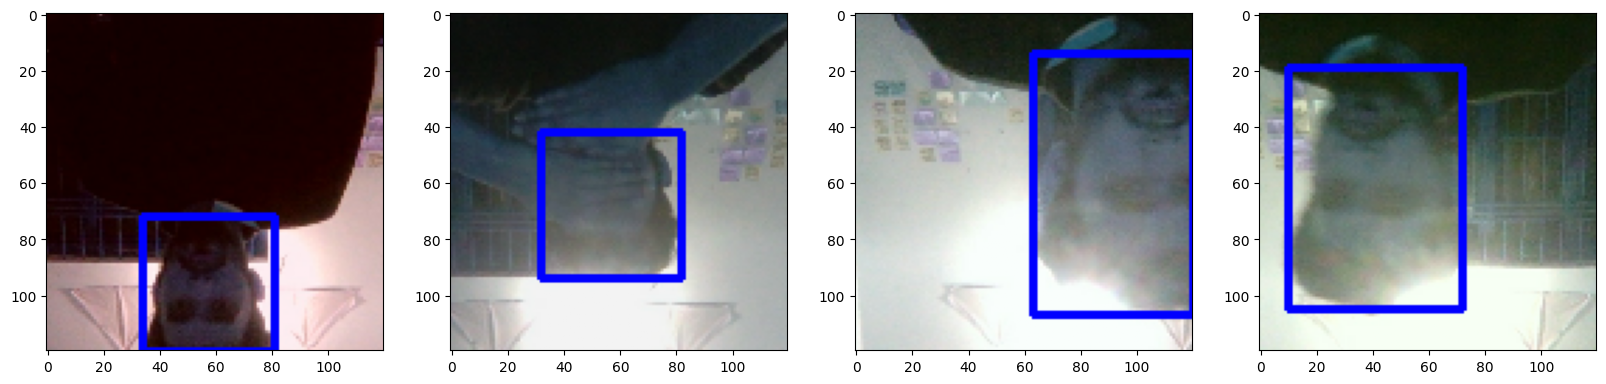

In [148]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = res[0][idx].copy()  # Make a writable copy of the image
    sample_coords = res[1][1][idx]

    # Calculate the coordinates
    pt1 = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    pt2 = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))

    # Draw the rectangle
    cv.rectangle(img=sample_image, pt1=pt1, pt2=pt2, color=(255, 0, 0), thickness=2)

    # Display the image with the rectangle
    ax[idx].imshow(cv.cvtColor(sample_image, cv.COLOR_BGR2RGB))  

plt.show()